# Individual Variability across cerebellum

In [1]:
import pandas as pd
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import seaborn as sb
import Functional_Fusion.dataset as ds
import ProbabilisticParcellation.util as ut
from copy import deepcopy
import ProbabilisticParcellation.learn_fusion_gpu as lf
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as sc
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.scripts.atlas_paper.symmetry as sm
import ProbabilisticParcellation.scripts.atlas_paper.describe_atlas as da
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.evaluation as ev
import Functional_Fusion.atlas_map as am
import SUITPy as suit
import os
import ProbabilisticParcellation.scripts.atlas_paper.individual_variability as var
import nitools as nt
import nibabel as nb


In [2]:
figure_path = "/Users/jdiedrichsen/Dropbox (Diedrichsenlab)/papers/AtlasPaper/figure_parts/"
if not os.path.exists(figure_path):
    figure_path = "/Users/callithrix/Dropbox/AtlasPaper/figure_parts/"
atlas_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'


In [3]:
# Settings

norm = True
subject_wise = True
sym = 'Asym'
K = 32
space = 'MNISymC2'
mname = f'Models_03/Nettekoven{sym}{K}_space-{space}'


In [4]:
# Get individual parcellations
try:
    probs_indiv = pt.load(f'{ut.model_dir}/Models/{mname}_Uhat.pt')
    probs_info = pd.read_csv(
        f'{ut.model_dir}/Models/{mname}_Uhat_info.tsv', sep='\t')
except FileNotFoundError:
    probs_indiv, probs_info = sm.export_uhats(
        mname=mname)
probs_indiv = probs_indiv.numpy()

In [5]:
# Get inter-individual variability for all datasets (optional: normalize by reliability)
datasets = probs_info['dataset'].unique()
Corr = []
for dataset in datasets:
    probs_dataset = probs_indiv[probs_info.dataset == dataset, :, :]
    corr_dataset = var.inter_individual_variability(
        probs_dataset, subject_wise=subject_wise)
    Corr.append(corr_dataset)
    corr_dataset = var.reliability_norm(
            corr_dataset, dataset, subject_wise=subject_wise)

In [ ]:
var.plot_variability(corr_dataset[0], save=False)

KeyboardInterrupt: 

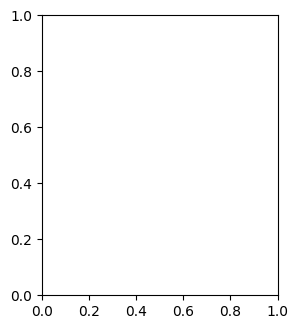

In [16]:
# Average across subjects within each dataset
mean_corr = np.array([np.nanmean(corr, axis=1) for corr in Corr])

# Plot for each dataset
plt.figure(figsize=(14, 8))
ut.plot_multi_flat(mean_corr, space,
                   grid=(2, 4),
                   dtype='func',
                   colorbar=True,
                   titles=probs_info['dataset'].unique(),
                   cmap='hot')


# Plot individual variability averaged for each parcel of Sym 32

In [10]:
mname = f'Models_03/NettekovenSym{K}_space-{space}'
_, cmap, labels = nt.read_lut(atlas_dir +
                              'NettekovenSym32.lut')
pseg = nb.load(atlas_dir + 'NettekovenSym32_space-MNISymC2_probseg.nii')

surf_data = suit.flatmap.vol_to_surf(pseg, stats='nanmean',
                                     space='MNISymC')
surf_parcel = np.argmax(surf_data, axis=1) + 1
surf_parcel = np.nan_to_num(surf_parcel, copy=False).astype(int)



In [ ]:
# Fill in the mean correlation for each parcel
show_corr = mean_corr[0]
sym_map = np.zeros(surf_parcel.shape) * np.nan
sym_map[surf_parcel > 0] = show_corr[surf_parcel[surf_parcel > 0] - 1]

# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(sym_map,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  colorbar=True,
                  cscale=(0,1),
                  cmap='hot')
plt.savefig(figure_path + 'Individual_variability_mdtb.png',
            dpi=300, bbox_inches='tight')
